# Step 2 - Prepare points of interest (POI) data
## Project: Growing Urban Bicycle Networks - with an LTN twist

This notebook downloads and prepares points of interest data to be used for bicycle network design, snapping them to the networks created in 01_prepare_networks:
* LTNs
* Hexagonal Tesselations within city boundary and external to LTNs
* railway stations
* grid points


Contact: Michael Szell (michael.szell@gmail.com) or Chris Larkin (c.larkin@ncl.ac.uk) 

Created: 2020-07-07  
Last modified: 2024-11-08

## Preliminaries

### Parameters

In [5]:
debug = True # If True, will produce plots and/or verbose output to double-check
%run -i "../parameters/parameters.py"

Loaded parameters.



### Setup

In [2]:
%run -i path.py
%run -i setup.py

%load_ext watermark
%watermark -n -v -m -g -iv

Loaded PATH.



=== Cities ===
{   'newcastle': {   'countryid': 'gbr',
                     'name': 'Newcastle upon Tyne',
                     'nominatimstring': 'Newcastle upon Tyne'}}


Setup finished.

Python implementation: CPython
Python version       : 3.12.6
IPython version      : 8.29.0

Compiler    : MSC v.1941 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 140 Stepping 1, GenuineIntel
CPU cores   : 8
Architecture: 64bit

Git hash: 915b29277f601bc30f903af12b6e67c3ddac7690

osmnx     : 1.9.4
csv       : 1.0
tqdm      : 4.66.5
shapely   : 2.0.6
sys       : 3.12.6 | packaged by conda-forge | (main, Sep 22 2024, 14:01:26) [MSC v.1941 64 bit (AMD64)]
owslib    : 0.32.0
pandas    : 2.2.3
igraph    : 0.11.6
networkx  : 3.3
rasterio  : 1.3.11
fiona     : 1.10.1
IPython   : 8.29.0
numpy     : 1.26.4
geopandas : 0.14.4
haversine : 2.8.1
pyproj    : 3.7.0
watermark : 2.5.0
geojson   : 3.1.0
matplotlib: 3.8.4
osgeo     : 3.

### Functions

In [3]:
%run -i functions.py

Loaded functions.



## Download and wrangle data

In [4]:
# Load all carall graphs in OSMNX format
G_caralls = {}
G_caralls_simplified = {}
G_biketracks = {}
locations = {}
parameterinfo = osmnxparameters['carall']

for placeid, placeinfo in tqdm(cities.items(), desc = "Cities"):
    print(placeid + ": Loading location polygon and carall graph")
    
    if placeinfo["nominatimstring"] != '':
        location = ox.geocoder.geocode_to_gdf(placeinfo["nominatimstring"])
        if location.geometry[0].geom_type == 'MultiPolygon':
            location = location.explode(index_parts=False).reset_index(drop=True)
        location = fill_holes(extract_relevant_polygon(placeid, shapely.geometry.shape(location['geometry'][0])))
    else:
        # https://gis.stackexchange.com/questions/113799/how-to-read-a-shapefile-in-python
        shp = fiona.open(PATH["data"] + placeid + "/" + placeid + ".shp")
        first = next(iter(shp))
        try:
            location = Polygon(shapely.geometry.shape(first['geometry'])) # If shape file is given as linestring
        except:
            location = shapely.geometry.shape(first['geometry'])
    locations[placeid] = location
    
    G_caralls[placeid] = csv_to_ox(PATH["data"] + placeid + "/", placeid, 'carall')
    G_caralls[placeid].graph["crs"] = 'epsg:4326' # needed for OSMNX's graph_to_gdfs in utils_graph.py
    G_caralls_simplified[placeid] = csv_to_ox(PATH["data"] + placeid + "/", placeid, 'carall_simplified')
    G_caralls_simplified[placeid].graph["crs"] = 'epsg:4326' # needed for OSMNX's graph_to_gdfs in utils_graph.py

    G_biketracks[placeid] = csv_to_ox(PATH["data"] + placeid + "/", placeid, 'biketrack')
    G_biketracks[placeid].graph["crs"] = 'epsg:4326' # needed for OSMNX's graph_to_gdfs in utils_graph.py

Cities:   0%|          | 0/1 [00:00<?, ?it/s]

newcastle: Loading location polygon and carall graph


### Tessellation

In [ ]:
# for placeid, placeinfo in tqdm(cities.items(), desc  = "Cities"):
#     print(placeid + ": Tesselation around neighbourhoods")
#     location = locations[placeid]
    
#     # get urban areas - we want seed points where people live, not countryside!
#     urban_areas = get_urban_areas(placeinfo["nominatimstring"])
    
#     tess = Tessellation(urban_areas) 
#     # if an error, add this line to the tessypy libarary: 
#     # df_qk_squares = df_qk_squares.drop(columns=["osm_id", "children_id"], errors='ignore')
#     tess.get_polygon()#.plot(figsize=(10, 10)).set_axis_off();
#     hexagons = tess.hexagons(resolution=8)
#     if debug:
#         hexagons.plot(lw=1, edgecolor="w", figsize=(10, 10)).set_axis_off();


#     # load any LTNs
#     neighbourhoods = load_neighbourhoods(PATH["data"] + placeid + "/")

#     # cut out ltns from neighbourhood boundary
#     neighbourhood_geoms = []
#     for gdf in neighbourhoods.values():
#         neighbourhood_geoms.extend(gdf['geometry'].values)
#     neighbourhoods_gdf = MultiPolygon(neighbourhood_geoms)
#     for neighbourhood_geom in neighbourhoods_gdf.geoms:
#         location = location.difference(neighbourhood_geom)
    
#     # set as a geodataframe
#     location_gseries = gpd.GeoSeries([location])
#     location_gdf = gpd.GeoDataFrame(geometry=location_gseries)
#     location_gdf = location_gdf.set_crs(epsg=4326, inplace=True)

#     # remove any hexagons which intersect with the neighbourhoods
#     hexagons = hexagons[~hexagons.intersects(gdf.unary_union)]
#     hexagon_centroids_gdf = gpd.GeoDataFrame(geometry=hexagons.centroid, crs=hexagons.crs)
#     if debug:
#         hexagon_centroids_gdf.plot(color='blue')






#     print(placeid + ": loading and moving POIs")
#     # We need the carall graph and location geometry
#     G_carall = G_caralls_simplified[placeid]
#     try:
#         gdf = hexagon_centroids_gdf
#         print(gdf.crs)

#         # Now snap to closest nodes in the street network and save the nearest node ids
#         nnids = set()
#         for g in gdf['geometry']:
#             # Find nearest node in the carall network
#             n = ox.distance.nearest_nodes(G_carall, g.x, g.y)
#             if n not in nnids and haversine((g.y, g.x), (G_carall.nodes[n]["y"], G_carall.nodes[n]["x"]), unit="m") <= snapthreshold:
#                 nnids.add(n)
#         nnids_csv_path = PATH["data"] + placeid + "/" + placeid + '_poi_' + 'tessellation' + '_nnidscarall.csv'
#         with open(nnids_csv_path, 'w') as f:
#             for item in nnids:
#                 f.write("%s\n" % item)

#         gdf = gdf.apply(lambda c: c.astype(str) if c.name != 'geometry' else c, axis=0)
#         gpkg_output_path = PATH["data"] + placeid + "/" + placeid + '_poi_' + 'tessellation' + '.gpkg'
#         try:
#             gdf.to_file(gpkg_output_path, driver='GPKG')
#         except Exception as e:
#             print(f"Notice: Writing the tesselation gdf did not work for {placeid}. Error: {e}")

#         # Optionally plot for debugging purposes
#         if debug:
#             gdf.plot(color='red')

#     except Exception as e:
#         print(f"No points created for {placeinfo['name']}. No POIs created. Error: {e}")


Cities:   0%|          | 0/1 [00:00<?, ?it/s]

newcastle: Tesselation around neighbourhoods


C:\Users\b8008458\OneDrive - Newcastle University\2022 to 2023\PhD\networkGrowth\bikenwgrowth\code\functions.py:2134: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_buffered['geometry'] = gdf['geometry'].buffer(buffer_distance)


1 Cities loaded
newcastle: loading and moving POIs


C:\Users\b8008458\AppData\Local\Temp\ipykernel_25068\497344237.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  hexagon_centroids_gdf = gpd.GeoDataFrame(geometry=hexagons.centroid, crs=hexagons.crs)
c:\Users\b8008458\AppData\Local\miniforge3\envs\growbikenet\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\Users\b8008458\AppData\Local\Temp\ipykernel_25068\497344237.py:57: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


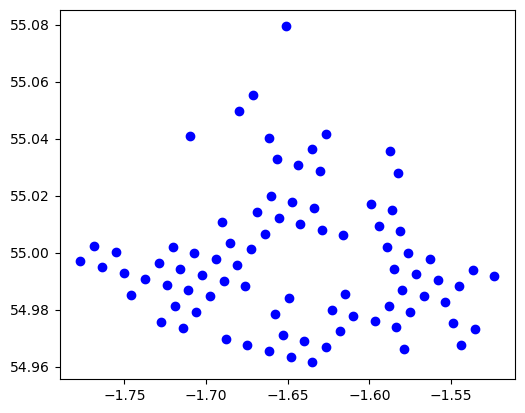

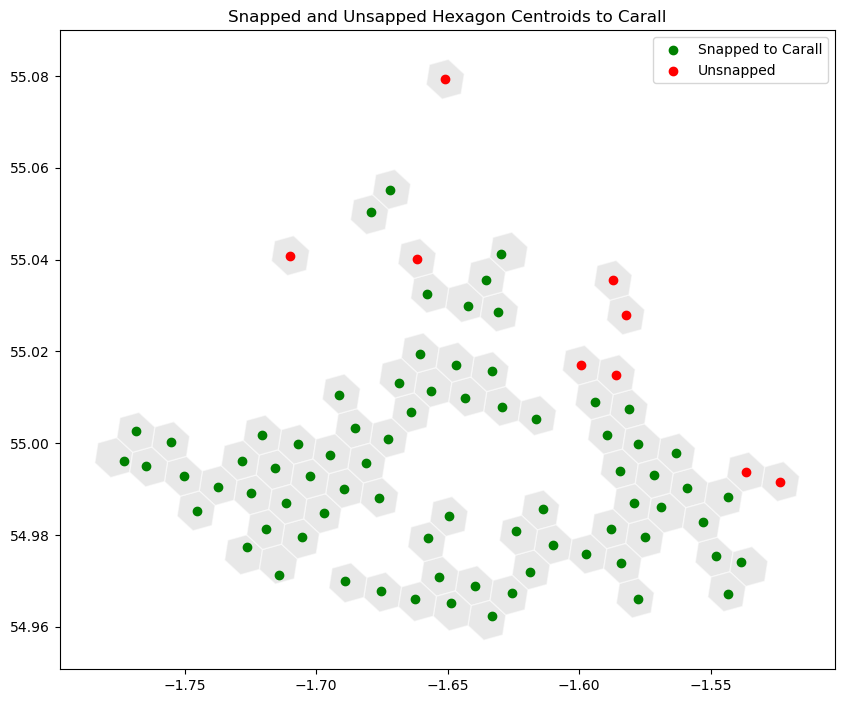

newcastle: Snapping to bike tracks


C:\Users\b8008458\AppData\Local\Temp\ipykernel_25068\497344237.py:82: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


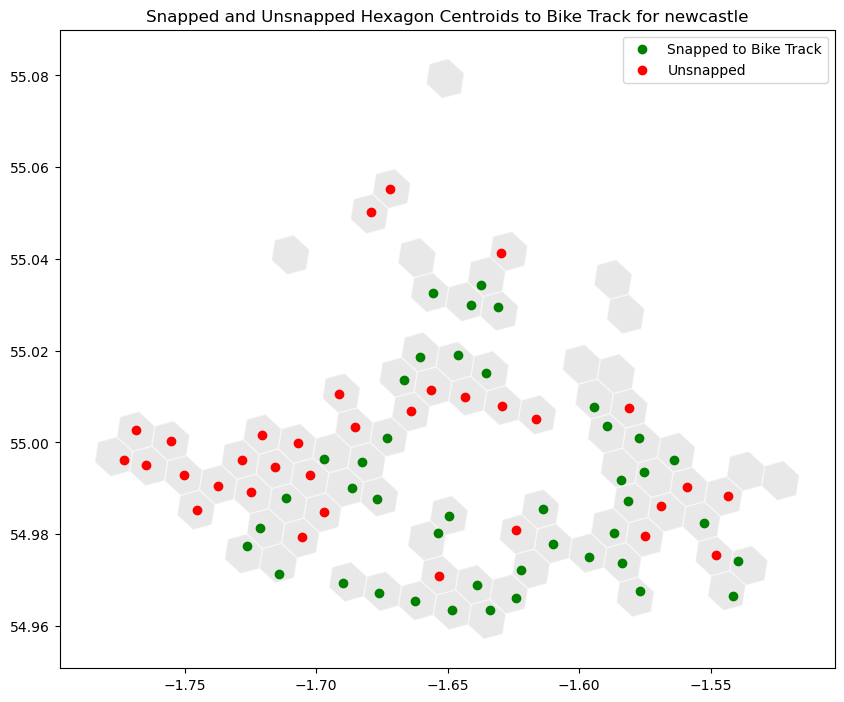

C:\Users\b8008458\AppData\Local\Temp\ipykernel_25068\497344237.py:102: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


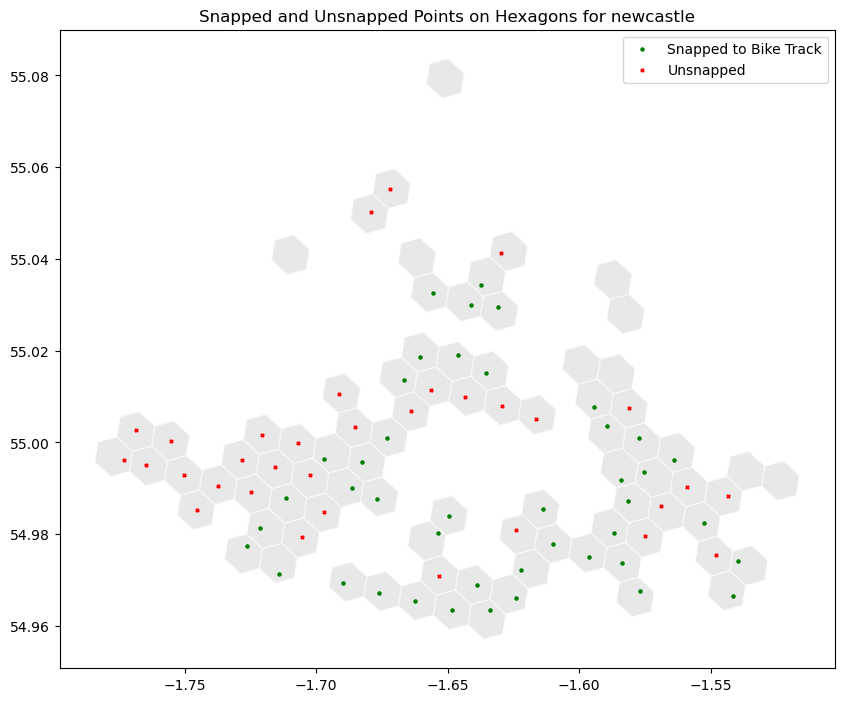

In [6]:
for placeid, placeinfo in tqdm(cities.items(), desc="Cities"):
    print(placeid + ": Tesselation around neighbourhoods")
    location = locations[placeid]
    
    # Get urban areas for seed points
    urban_areas = get_urban_areas(placeinfo["nominatimstring"])
    tess = Tessellation(urban_areas)
    tess.get_polygon()  # Optional plot for debugging
    hexagons = tess.hexagons(resolution=8)
    
    # Load LTNs
    neighbourhoods = load_neighbourhoods(PATH["data"] + placeid + "/")
    neighbourhood_geoms = [geom for gdf in neighbourhoods.values() for geom in gdf['geometry'].values]
    neighbourhoods_gdf = MultiPolygon(neighbourhood_geoms)
    for neighbourhood_geom in neighbourhoods_gdf.geoms:
        location = location.difference(neighbourhood_geom)
    
    
    # Set location as a GeoDataFrame
    location_gdf = gpd.GeoDataFrame(geometry=[location], crs="EPSG:4326")
    
    # Remove hexagons that intersect with neighbourhoods
    hexagons = hexagons[~hexagons.intersects(neighbourhoods_gdf)]
    hexagon_centroids_gdf = gpd.GeoDataFrame(geometry=hexagons.centroid, crs=hexagons.crs)
    
    if debug:
        hexagon_centroids_gdf.plot(color='blue')

    print(placeid + ": loading and moving POIs")
    # load networks
    G_carall = G_caralls_simplified[placeid]
    G_biketrack = G_biketracks[placeid]
    
    # First snap points to the carall network
    updated_points = []
    for g in hexagon_centroids_gdf['geometry']:
        # Find nearest node in the carall network
        n = ox.distance.nearest_nodes(G_carall, g.x, g.y)
        
        # Check distance to the nearest node
        distance_to_nearest_node = haversine((g.y, g.x), (G_carall.nodes[n]["y"], G_carall.nodes[n]["x"]), unit="m")
        if distance_to_nearest_node <= snapthreshold:
            snapped_point = Point(G_carall.nodes[n]["x"], G_carall.nodes[n]["y"])
            updated_points.append({'geometry': snapped_point, 'snap_status': 'snapped'})
        else:
            updated_points.append({'geometry': g, 'snap_status': 'unsnapped'})
    
    # Convert to GeoDataFrame
    snapped_gdf = gpd.GeoDataFrame(updated_points, crs=hexagon_centroids_gdf.crs)
    snapped_carall = snapped_gdf[snapped_gdf['snap_status'] != 'unsnapped']
    
    if debug:
        fig, ax = plt.subplots(figsize=(10, 10))
        hexagons.plot(ax=ax, color="lightgray", edgecolor="white", alpha=0.5, label="Hexagons")
        snapped_gdf[snapped_gdf['snap_status'] == 'snapped'].plot(ax=ax, color='green', label='Snapped to Carall')
        snapped_gdf[snapped_gdf['snap_status'] == 'unsnapped'].plot(ax=ax, color='red', label='Unsnapped')
        plt.legend()
        plt.title("Snapped and Unsapped Hexagon Centroids to Carall")
        plt.show()

    print(placeid + ": Snapping to bike tracks")
    
    # Now snap to bike track network
    updated_bike_points = []
    for g in snapped_carall['geometry']:
        n = ox.distance.nearest_nodes(G_biketrack, g.x, g.y)
        distance_to_nearest_bike_node = haversine((g.y, g.x), (G_biketrack.nodes[n]["y"], G_biketrack.nodes[n]["x"]), unit="m")
        if distance_to_nearest_bike_node <= snapthreshold:
            snapped_bike_point = Point(G_biketrack.nodes[n]["x"], G_biketrack.nodes[n]["y"])
            updated_bike_points.append({'geometry': snapped_bike_point, 'snap_status': 'snapped'})
        else:
            updated_bike_points.append({'geometry': g, 'snap_status': 'unsnapped'})
    
    # Convert to final GeoDataFrame
    snapped_biketrack = gpd.GeoDataFrame(updated_bike_points, crs=hexagon_centroids_gdf.crs)
    
    if debug:
        fig, ax = plt.subplots(figsize=(10, 10))
        hexagons.plot(ax=ax, color="lightgray", edgecolor="white", alpha=0.5, label="Hexagons")
        snapped_biketrack[snapped_biketrack['snap_status'] == 'snapped'].plot(ax=ax, color='green', label='Snapped to Bike Track')
        snapped_biketrack[snapped_biketrack['snap_status'] == 'unsnapped'].plot(ax=ax, color='red', label='Unsnapped')
        plt.legend()
        plt.title(f"Snapped and Unsnapped Hexagon Centroids to Bike Track for {placeid}")
        plt.show()

    if debug:
        # Plot the hexagons and snapped_biketrack points
        fig, ax = plt.subplots(figsize=(10, 10))

        # Plot hexagons as the background layer
        hexagons.plot(ax=ax, color="lightgray", edgecolor="white", alpha=0.5, label="Hexagons")

        # Overlay the snapped_biketrack points
        snapped_biketrack[snapped_biketrack['snap_status'] == 'snapped'].plot(
            ax=ax, color='green', marker='o', markersize=5, label="Snapped to Bike Track"
        )
        snapped_biketrack[snapped_biketrack['snap_status'] == 'unsnapped'].plot(
            ax=ax, color='red', marker='x', markersize=5, label="Unsnapped"
        )

        # Customize plot appearance
        plt.legend()
        plt.title(f"Snapped and Unsnapped Points on Hexagons for {placeid}")


        # Show the plot
        plt.show()


    # Save the final snapped points' nearest node IDs for bike track
    nnids = set()
    for g in snapped_biketrack[snapped_biketrack['snap_status'] == 'snapped']['geometry']:
        n = ox.distance.nearest_nodes(G_biketrack, g.x, g.y)
        nnids.add(n)

    # Write to CSV and GPKG
    nnids_csv_path = PATH["data"] + placeid + "/" + placeid + '_poi_tessellation_nnidbike.csv'
    with open(nnids_csv_path, 'w') as f:
        for item in nnids:
            f.write("%s\n" % item)

    gpkg_output_path = PATH["data"] + placeid + "/" + placeid + '_poi_tessellation.gpkg'
    try:
        snapped_biketrack.to_file(gpkg_output_path, driver='GPKG')
    except Exception as e:
        print(f"Notice: Writing the tessellation gdf did not work for {placeid}. Error: {e}")

### Neighbourhood centroids

In [ ]:
for placeid, placeinfo in tqdm(cities.items(), desc="Cities"):
    print(placeid + ": loading and moving POIs")

    # We need the carall graph and location geometry
    location = locations[placeid]
    G_carall = G_caralls_simplified[placeid]

    # Load POIs from your local GeoPackage instead of OpenStreetMap
    gpkg_path = f"../../ltnConnect_external/exports/{placeinfo['nominatimstring']}_centroids.gpkg"

    # Read POIs from the local GeoPackage
    try:
        gdf = gpd.read_file(gpkg_path)
        print(gdf.crs)

        # Now snap to closest nodes in the street network and save the nearest node ids
        nnids = set()
        for g in gdf['geometry']:
            # Find nearest node in the carall network
            n = ox.distance.nearest_nodes(G_carall, g.x, g.y)
            if n not in nnids and haversine((g.y, g.x), (G_carall.nodes[n]["y"], G_carall.nodes[n]["x"]), unit="m") <= snapthreshold:
                nnids.add(n)
        nnids_csv_path = PATH["data"] + placeid + "/" + placeid + '_poi_' + 'neighbourhoods' + '_nnidscarall.csv'
        with open(nnids_csv_path, 'w') as f:
            for item in nnids:
                f.write("%s\n" % item)

        gdf = gdf.apply(lambda c: c.astype(str) if c.name != 'geometry' else c, axis=0)
        gpkg_output_path = PATH["data"] + placeid + "/" + placeid + '_poi_' + 'neighbourhoods' + '.gpkg'
        try:
            gdf.to_file(gpkg_output_path, driver='GPKG')
        except Exception as e:
            print(f"Notice: Writing the gdf did not work for {placeid}. Error: {e}")

        # Optionally plot for debugging purposes
        if debug:
            gdf.plot(color='red')

    except Exception as e:
        print(f"No Centroids created for {placeinfo['name']}. No POIs created. Error: {e}")


### Railway stations/halts and bus stops

In [ ]:
# Here POIs are downloaded and matched to the network. To ensure consistent reproducibility, we should download POIs only once, then load them locally. For now we leave it as is, as POIs are not expected to change fast.

for placeid, placeinfo in tqdm(cities.items(), desc = "Cities"):
    print(placeid + ": Creating POIs")
    
    # We need the carall graph and location geometry
    location = locations[placeid]
    G_carall = G_caralls_simplified[placeid]
    
    for poiid, poitag in poiparameters.items():
        try:
            gdf = ox.geometries.geometries_from_polygon(location, poitag)
            gdf = gdf[gdf['geometry'].type == "Point"] # only consider points, no polygons etc
            # Now snap to closest nodes in street network, save the nearest node ids
            nnids = set()
            for g in gdf['geometry']:
                n = ox.distance.nearest_nodes(G_carall, g.x, g.y) # !! get_nearest_node() had [y(lat),x(lon)], now nearest_nodes() has x(lon),y(lat)
                if not n in nnids and haversine((g.y, g.x), (G_carall.nodes[n]["y"], G_carall.nodes[n]["x"]), unit="m") <= snapthreshold:
                    nnids.add(n)
            with open(PATH["data"] + placeid + "/" + placeid + '_' + 'poi_' + poiid + '_nnidscarall.csv', 'w') as f:
                for item in nnids:
                    f.write("%s\n" % item)
    
            gdf = gdf.apply(lambda c: c.astype(str) if c.name != 'geometry' else c, axis=0)
            try: # For some cities writing the gdf does not work (i.e. London, Manhattan)
                gdf.to_file(PATH["data"] + placeid + "/" + placeid + '_' + 'poi_' + poiid + '.gpkg', driver = 'GPKG')
            except:
                print("Notice: Writing the gdf did not work for " + placeid)
            if debug: gdf.plot(color = 'red')
        except:
            print("No stations in " + placeinfo["name"] + ". No POIs created.")

### Grid

Using code from: https://github.com/gboeing/osmnx-examples/blob/v0.11/notebooks/17-street-network-orientations.ipynb

In [ ]:
for placeid, placeinfo in tqdm(cities.items(), desc  = "Cities"):
    print(placeid + ": Creating grid")
    
    location = locations[placeid]
    
    
    
    # FIRST, determine the most common bearing, for the best grid orientation
    G = G_caralls[placeid]
    bearings = {}    
    # calculate edge bearings
    Gu = ox.bearing.add_edge_bearings(ox.get_undirected(G))

    # weight bearings by length (meters)
    city_bearings = []
    for u, v, k, d in Gu.edges(keys = True, data = True):
        city_bearings.extend([d['bearing']] * int(d['length']))
    b = pd.Series(city_bearings)
    bearings = pd.concat([b, b.map(reverse_bearing)]).reset_index(drop = 'True')

    bins = np.arange(bearingbins + 1) * 360 / bearingbins
    count = count_and_merge(bearingbins, bearings)
    principalbearing = bins[np.where(count == max(count))][0]
    if debug: 
        print("Principal bearing: " + str(principalbearing))


    # SECOND, construct the grid
    G = G_caralls_simplified[placeid]

    # 1) Get lat lon window, with buffer for snapping outside POIs
    # https://stackoverflow.com/questions/7477003/calculating-new-longitude-latitude-from-old-n-meters
    buf = max(((2*snapthreshold) / 6378000) * (180 / math.pi), 
              ((2*snapthreshold) / 6378000) * (180 / math.pi) / math.cos(location.centroid.y * math.pi/180)
             )
    cities[placeid]["bbox"] = location.buffer(buf).bounds

    # 2) Generate abstract grid points in window
    # https://stackoverflow.com/questions/40342355/how-can-i-generate-a-regular-geographic-grid-using-python
    # Set up projections
    p_ll = pyproj.Proj('+proj=longlat +datum=WGS84')
    aeqd_proj = '+proj=aeqd +lat_0={lat} +lon_0={lon} +x_0=0 +y_0=0'
    p_mt = pyproj.Proj(aeqd_proj.format(lat=location.centroid.y, lon=location.centroid.x)) # equidistant projection

    # Make the area larger to account for tilted grid
    deltax = cities[placeid]["bbox"][2] - cities[placeid]["bbox"][0]
    deltay = cities[placeid]["bbox"][3] - cities[placeid]["bbox"][1]
    enlargefactor = 10

    # Create corners of rectangle to be transformed to a grid
    sw = shapely.geometry.Point((cities[placeid]["bbox"][0], cities[placeid]["bbox"][1]))
    ne = shapely.geometry.Point((cities[placeid]["bbox"][2]+enlargefactor*deltax, cities[placeid]["bbox"][3]+enlargefactor*deltay))
    
    # Project corners to target projection
    transformed_sw = pyproj.transform(p_ll, p_mt, sw.x, sw.y) # Transform NW point to equidistant
    transformed_ne = pyproj.transform(p_ll, p_mt, ne.x, ne.y) # .. same for SE

    # Iterate over 2D area
    principalbearing = principalbearing % 90 # Take it modulo 90 because it will be a square grid
    if principalbearing > 45:
        principalbearing -= 90 # Make bearing fall btw -45 and 45

    xcoords = np.arange(transformed_sw[0], transformed_ne[0], gridl)
    ycoords = np.arange(transformed_sw[1], transformed_ne[1], gridl)
    xsize =  xcoords.size
    ysize = ycoords.size
    xcoords = np.tile(xcoords, ysize)
    ycoords = np.repeat(ycoords, xsize)
    gridpoints=[(x, y) for x, y in zip(xcoords, ycoords)]
    new_points = rotate_grid(gridpoints, origin = transformed_sw, degrees = principalbearing)
    
    # https://stackoverflow.com/questions/42459068/projecting-a-numpy-array-of-coordinates-using-pyproj
    fx, fy = pyproj.transform(p_mt, p_ll, new_points[:,0], new_points[:,1])
    gridpoints = np.dstack([fx, fy])[0]
    if principalbearing >=0:
        # If we rotated right, we need to shift everything to the left
        gridpoints[:,0] -= 0.4*enlargefactor*deltax*math.sin(np.deg2rad(principalbearing))
    else:
        # If we rotated left, we need to shift everything down and to the right
        gridpoints[:,0] += 0.4*enlargefactor*deltax*math.sin(np.deg2rad(principalbearing))
        gridpoints[:,1] -= 0.4*enlargefactor*deltay

    # Cut back to bounding box
    mask = (gridpoints[:,0] >= cities[placeid]["bbox"][0]) & (gridpoints[:,0] <= cities[placeid]["bbox"][2]) & (gridpoints[:,1] >= cities[placeid]["bbox"][1]) & (gridpoints[:,1] <= cities[placeid]["bbox"][3])
    gridpoints_cut = gridpoints[mask]
    
    if debug:
        fig = plt.figure(figsize=[2*6.4, 2*4.8])
        ax = fig.add_axes([0, 0, 1, 1])
        ax.set_aspect('equal', adjustable = 'datalim')
        plt.plot([g[0] for g in gridpoints_cut], [g[1] for g in gridpoints_cut], ".", color = "red")

    # 3) Snap grid points to map
    nnids = set()
    for g in gridpoints_cut:
        n = ox.distance.nearest_nodes(G, g[0], g[1]) # !! get_nearest_node() had [y(lat),x(lon)], now nearest_nodes() has x(lon),y(lat)
        if n not in nnids and haversine((g[1], g[0]), (G.nodes[n]["y"], G.nodes[n]["x"]), unit="m") <= snapthreshold:
            nnids.add(n)
    with open(PATH["data"] + placeid + "/" + placeid + '_poi_grid_nnidscarall.csv', 'w') as f:
        for item in nnids:
            f.write("%s\n" % item)
    
    # 4) Save grid points to geopackage
    geometry = [Point(xy) for xy in gridpoints_cut]  # Convert each point to a Shapely Point object
    gdf = gpd.GeoDataFrame(geometry=geometry, crs="EPSG:4326")  # Create GeoDataFrame, assuming EPSG:4326 for WGS84
    
    # Ensure all columns except geometry are strings for consistency with your POI export
    gdf = gdf.apply(lambda c: c.astype(str) if c.name != 'geometry' else c, axis=0)

    # Try writing the grid points to a GeoPackage
    try:
        gdf.to_file(PATH["data"] + placeid + "/" + placeid + '_poi_grid.gpkg', driver='GPKG')
        print(f"Grid points written to GeoPackage for {placeid}")
    except Exception as e:
        print(f"Notice: Writing the grid points to GeoPackage did not work for {placeid}: {str(e)}")

    if debug:
        gdf.plot(color='blue')

### Population density (for now commented out as unfinished: data not reliable enough)

In [30]:
# # https://medium.com/@danielmoyo/raster-data-in-python-part-i-reading-and-visualising-raster-data-95cb072fcbfa
# import rasterio

# densityfolder = "populationdensity"
# for placeid, placeinfo in cities.items():
#     raster_path = PATH["data"] + densityfolder + "/" + placeinfo['countryid'] + "_ppp_2020_UNadj.tif"
#     pop_raster = rasterio.open(raster_path)
    
#     cities[placeid]["bbox"] = location.bounds

#     def plot_raster(arr, title=None, figsize=(30,10)):
#         """ helper function to plot a raster array """
#         fig, ax = plt.subplots(figsize=figsize)
#         plt.imshow(arr)
#         plt.colorbar()
#         plt.title(f'{title}')
#         plt.xlabel('Column #')
#         plt.ylabel('Row #')
#         return fig, ax

#     pop_data = pop_raster.read(1)
#     pop_data[pop_data<0] = 0
#     pop_count = pop_data[pop_data>0].sum()
#     plot_raster(pop_data, title=pop_count)

In [31]:
# # https://stackoverflow.com/questions/50191648/gis-geotiff-gdal-python-how-to-get-coordinates-from-pixel
# # https://gdal.org/api/gdaldataset_cpp.html#_CPPv4N11GDALDataset15GetGeoTransformEPd

# # Problems:
# # https://gis.stackexchange.com/questions/331908/notimplementederror-wrong-number-or-type-of-arguments-for-overloaded-function
# # https://gis.stackexchange.com/questions/44040/osr-python-testsr-importfromepsg4326-returns-empty-spatial-reference
# # https://www.programcreek.com/python/example/58591/osgeo.osr.SpatialReference


# def generate_latlons(raster_path):
#     # open the dataset and get the geo transform matrix
#     ds = gdal.Open(raster_path) 
#     xoffset, px_w, rot1, yoffset, px_h, rot2 = ds.GetGeoTransform()
#     ds_arr = ds.ReadAsArray()
    
#     x_arr = np.arange(0, ds_arr.shape[0], 1)
#     x_arr.shape = (len(x_arr), 1)
#     x_arr = np.repeat(x_arr, [ds_arr.shape[1]], axis=1)
    
#     y_arr = np.arange(0, ds_arr.shape[1], 1)
#     y_arr.shape = (1, len(y_arr))
#     y_arr = np.repeat(y_arr, [ds_arr.shape[0]], axis=0)
    
#     # supposing x and y are your pixel coordinate this 
#     # is how to get the coordinate in space.
#     lon_arr = xoffset + px_w * y_arr + rot1 * x_arr + px_w / 2.0
#     lat_arr = yoffset + px_h * y_arr + rot2 * x_arr + px_h / 2.0
    
#     return(lat_arr, lon_arr)

# for placeid, placeinfo in cities.items():
#     raster_path = PATH["data"] + densityfolder + "/" + placeinfo['countryid'] + "_ppp_2020_UNadj.tif"
#     pop_raster = rasterio.open(raster_path)
#     (lat, lon) = generate_latlons(raster_path)
    
# # To do: only read the relevant window
# # https://medium.com/@danielmoyo/raster-data-in-python-part-ii-working-with-geographic-coordinates-a368708de5f2

In [32]:
# indices = np.where(pop_data == pop_data.max())
# c_x = indices[0].item()
# c_y = indices[1].item()

# delta = 60
# plot_raster(pop_data[c_x-delta:c_x+delta, c_y-delta:c_y+delta], title="Population density, Copenhagen")

In [ ]:
Audio(sound_file, autoplay=True)